# PDM Data Summary



## TODO:

- distribution of # of slides per patient and sample (when relevant) from HoBBIT down the PDM tables
- compare the distribution of various columns from HoBBIT down the PDM tables 
 - overall, stratified by cancer type
 - number of slides, part_type, part_description stain_name, stain_group, scanner_id, brand, model, image_id 	magnification
- Look at strange values for the above fields, and see if there are values in the HoBBIT table that aren't in the subsequent PDM tables or vice versa
- using the above, put together questions for Luke
 - The duplicate slide IDs, invalid MRNs
 - 

In [21]:

import os
import pandas as pd
import sys
import getpass
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../")

from connector import DremioDataframeConnector
pd.set_option('display.max_columns', None)

FONT_BASE = {
    "family": "sans-serif",
    "sans-serif": "helvetica",
    "weight": "normal",
    "size": 18,
}

plt.rc("font", **FONT_BASE)
plt.rc("axes", unicode_minus=False)
from matplotlib import rcParams
plt.rcParams.update({'figure.autolayout': True})


def mrn_zero_pad(df: pd.DataFrame, col_mrn: str) -> pd.DataFrame:
    """zero pad MRN columns"""
    df[col_mrn] = df[col_mrn].astype(str).str.zfill(8)
    return df

def plot_hist(df, col_sample, col_patient):
    """plots # of samples/slides per patient"""
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 8)) #, figsize=(32,32))

    df_sample = df.groupby(by=[col_patient])[col_sample].nunique()\
        .reset_index(name='count')\
        .sort_values(['count'], ascending=False).reset_index()
    
    bins = np.arange(1,df_sample['count'].max()+1)
    counts, edges, bars = ax1.hist(df_sample['count'], bins=bins)
    ax1.set_xticks(bins)
    plt.bar_label(bars)
    plt.title(f"Number of {col_sample} per {col_patient}")
    plt.show()

In [2]:
# Setup Dremio connector
# Credentials (also could be read via .env)

DREMIO_USER = input("Username: ")
DREMIO_PASSWORD = getpass.getpass(prompt="Password or PAT: ", stream=None)

dremio_session = DremioDataframeConnector(
   scheme="grpc+tcp",
   hostname="tlvidreamcord1",
   flightport=32010,
   dremio_user=DREMIO_USER,
   dremio_password=DREMIO_PASSWORD,
   connection_args={},
)



Username: kohlia
Password or PAT: ········


## Loading data sources

Following code blocks are for loading in data sources (hobbit & IMPACT/CDM) and doing preliminary filtering and plotting

In [69]:
query = 'select * from "hobbit-poc"."case_breakdown"'
df_hobbit = dremio_session.get_table(query)
display(df_hobbit)

[INFO] Query:  select * from "hobbit-poc"."case_breakdown"


,mrn,specnum_formatted,specclass_id,subspecialty,priority,reduced_priority,datetime_accession,signout_datetime,part_inst,part_designator,part_type,part_description,block_inst,blkdesig_label,barcode,stain_inst,stain_name,stain_group,scanner_id,brand,model,image_id,magnification,status_id,file_size_bytes,captured_datetime
0,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,1,1,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC RIGHT, (VVS-06...",NaN,None,S06-26206;S1;MSKQ,1,None,None,IPTH9025,aperio,AT2,1006098,20x,$ready,8.400788e+08,2018-03-29 03:22:00
1,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,2,2,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC LEFT, (VVS-06-...",NaN,None,S06-26206;S2;MSKR,2,None,None,IPTH9025,aperio,AT2,1006102,20x,$updated,1.151277e+09,2018-03-29 03:25:00
2,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,2,2,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC LEFT, (VVS-06-...",NaN,None,S06-26206;S2;MSKR,2,None,None,IPTH9025,aperio,AT2,1006106,20x,$updated,9.570065e+08,2018-03-29 03:28:00
3,35039238,S04-43827,R,.GYN,C3,inhouse-surgical,2004-12-06 10:09:09.027,2004-12-09 19:19:54.897,2,2,SMALL BOWEL; BIOPSY,SP: Small bowel (fs) (pjm),NaN,None,S04-43827;S34;MSKS,34,None,None,IPTH9007,aperio,AT2,1011421,20x,$ready,8.993040e+08,2018-04-04 16:55:00
4,00673679,S00-12444,R,None,C,inhouse-surgical,2000-04-24 15:57:00.000,2000-04-28 07:55:00.000,2,2,FROZEN SECTION (FIRST),SP: Prostate and seminal vesicles (fs)(cg),NaN,None,S00-12444;S7;MSKP,7,None,None,IPTH9007,aperio,AT2,1022373,20x,$ready,2.337103e+09,2018-04-14 01:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6277512,35163877,S15-55469,R,None,C4,inhouse-surgical,2015-10-02 15:41:19.530,2015-10-09 20:15:38.800,5,5,BREAST; LUMPECTOMY/EXCISION,"Breast, right, medial margin",25.0,3 SS,S15-55469;S25;MSKP,25,"H&E, Initial",H&E (Initial),SS12004,aperio,GT450,4063822,40x,$ready,1.406952e+09,2021-02-22 17:16:00
6277513,38146362,H21-831,HSSL,.Heme,Submitted+,consult,2021-02-04 10:22:13.110,2021-02-17 11:40:43.900,1,1,SURGICAL SUBMITTED SLIDES,"Biopsies, left parietal bone (60-S-20-012098, ...",2.0,60S20-12098_2B,H21-831;S8;MSKW,8,CD3 (Leu4),None,SS12029,aperio,GT450,4063823,40x,$ready,9.162542e+08,2021-02-22 17:20:00
6277514,38142311,M21-5713,DM,.GI,DM1,other,2021-02-12 16:51:48.343,2021-03-05 15:49:10.077,1,1,DM SUBMITTED SLIDES,"Liver; biopsy (MSK:S21-1546/1-2 GI, DOP:1/8/20...",NaN,None,M21-5713;S2;MSKZ,2,DM H&E RECUT,H&E (Other),IPTH9026,aperio,AT2,4063824,20x,$ready,1.230379e+08,2021-02-22 17:19:00
6277515,00995151,S21-8498,R,.GI,Surgical,inhouse-surgical,2021-02-09 16:11:20.550,2021-02-17 15:28:53.453,1,1,ESOPHAGUS; ESOPHAGECTOMY,Esophagogastrectomy freeze esophageal margin (fs),1.0,1 FSC,S21-8498;S1;MSKG,1,"H&E, Initial",H&E (Initial),IPTHE006,aperio,AT2,4063825,20x,$ready,2.486275e+08,2021-02-22 17:19:00


In [71]:
# Processing df_hobbit like in HoBBIT-case-breakdown-summary
df_hobbit = df_hobbit.drop_duplicates()
ids = df_hobbit['image_id']
df_stain_dups = df_hobbit[ids.isin(ids[ids.duplicated()])].sort_values("image_id")
df_hobbit = df_hobbit[~df_hobbit['mrn'].isin(df_stain_dups['mrn'])]
# also removing incorrect MRNs
invalid_mrns = ['bsbsbs', 'GP102021LC', 'DMP12345']
df_hobbit = df_hobbit[~(df_hobbit['mrn'].isin(invalid_mrns))]
display(df_hobbit)

,mrn,specnum_formatted,specclass_id,subspecialty,priority,reduced_priority,datetime_accession,signout_datetime,part_inst,part_designator,part_type,part_description,block_inst,blkdesig_label,barcode,stain_inst,stain_name,stain_group,scanner_id,brand,model,image_id,magnification,status_id,file_size_bytes,captured_datetime
0,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,1,1,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC RIGHT, (VVS-06...",NaN,None,S06-26206;S1;MSKQ,1,None,None,IPTH9025,aperio,AT2,1006098,20x,$ready,8.400788e+08,2018-03-29 03:22:00
1,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,2,2,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC LEFT, (VVS-06-...",NaN,None,S06-26206;S2;MSKR,2,None,None,IPTH9025,aperio,AT2,1006102,20x,$updated,1.151277e+09,2018-03-29 03:25:00
2,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,2,2,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC LEFT, (VVS-06-...",NaN,None,S06-26206;S2;MSKR,2,None,None,IPTH9025,aperio,AT2,1006106,20x,$updated,9.570065e+08,2018-03-29 03:28:00
3,35039238,S04-43827,R,.GYN,C3,inhouse-surgical,2004-12-06 10:09:09.027,2004-12-09 19:19:54.897,2,2,SMALL BOWEL; BIOPSY,SP: Small bowel (fs) (pjm),NaN,None,S04-43827;S34;MSKS,34,None,None,IPTH9007,aperio,AT2,1011421,20x,$ready,8.993040e+08,2018-04-04 16:55:00
4,00673679,S00-12444,R,None,C,inhouse-surgical,2000-04-24 15:57:00.000,2000-04-28 07:55:00.000,2,2,FROZEN SECTION (FIRST),SP: Prostate and seminal vesicles (fs)(cg),NaN,None,S00-12444;S7;MSKP,7,None,None,IPTH9007,aperio,AT2,1022373,20x,$ready,2.337103e+09,2018-04-14 01:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6277512,35163877,S15-55469,R,None,C4,inhouse-surgical,2015-10-02 15:41:19.530,2015-10-09 20:15:38.800,5,5,BREAST; LUMPECTOMY/EXCISION,"Breast, right, medial margin",25.0,3 SS,S15-55469;S25;MSKP,25,"H&E, Initial",H&E (Initial),SS12004,aperio,GT450,4063822,40x,$ready,1.406952e+09,2021-02-22 17:16:00
6277513,38146362,H21-831,HSSL,.Heme,Submitted+,consult,2021-02-04 10:22:13.110,2021-02-17 11:40:43.900,1,1,SURGICAL SUBMITTED SLIDES,"Biopsies, left parietal bone (60-S-20-012098, ...",2.0,60S20-12098_2B,H21-831;S8;MSKW,8,CD3 (Leu4),None,SS12029,aperio,GT450,4063823,40x,$ready,9.162542e+08,2021-02-22 17:20:00
6277514,38142311,M21-5713,DM,.GI,DM1,other,2021-02-12 16:51:48.343,2021-03-05 15:49:10.077,1,1,DM SUBMITTED SLIDES,"Liver; biopsy (MSK:S21-1546/1-2 GI, DOP:1/8/20...",NaN,None,M21-5713;S2;MSKZ,2,DM H&E RECUT,H&E (Other),IPTH9026,aperio,AT2,4063824,20x,$ready,1.230379e+08,2021-02-22 17:19:00
6277515,00995151,S21-8498,R,.GI,Surgical,inhouse-surgical,2021-02-09 16:11:20.550,2021-02-17 15:28:53.453,1,1,ESOPHAGUS; ESOPHAGECTOMY,Esophagogastrectomy freeze esophageal margin (fs),1.0,1 FSC,S21-8498;S1;MSKG,1,"H&E, Initial",H&E (Initial),IPTHE006,aperio,AT2,4063825,20x,$ready,2.486275e+08,2021-02-22 17:19:00


In [73]:
print(f"Number of patients: {len(df_hobbit['mrn'].unique())}")
print(f"Number of slides: {len(df_hobbit['image_id'].unique())}")
print(f"Number of rows: {len(df_hobbit)}")
print(f"Number of rows (removing duplicates): {len(df_hobbit.drop_duplicates())}")

Number of patients: 367079
Number of slides: 6100645
Number of rows: 6100645
Number of rows (removing duplicates): 6100645


In [76]:


query = 'select * from impact."daily_data_clinical_sample.oncokb.txt"'
df_sample = dremio_session.get_table(query)

display(df_sample)

query = 'select * from impact."daily_data_clinical_patient.solid_heme.txt"'
df_patient = dremio_session.get_table(query).drop(0)

display(df_patient)

df_impact = df_sample.merge(df_patient, on="PATIENT_ID", how='inner')
display(df_impact)

[INFO] Query:  select * from impact."daily_data_clinical_sample.oncokb.txt"


,SAMPLE_ID,PATIENT_ID,GLEASON_SAMPLE_LEVEL,PDL1_POSITIVE,MONTH_ADDED,WEEK_ADDED,CANCER_TYPE,SAMPLE_TYPE,SAMPLE_CLASS,METASTATIC_SITE,PRIMARY_SITE,CANCER_TYPE_DETAILED,GENE_PANEL,SO_COMMENTS,SAMPLE_COVERAGE,TUMOR_PURITY,ONCOTREE_CODE,MSI_COMMENT,MSI_SCORE,MSI_TYPE,INSTITUTE,SOMATIC_STATUS,ARCHER,CVR_TMB_COHORT_PERCENTILE,CVR_TMB_SCORE,CVR_TMB_TT_COHORT_PERCENTILE,PATH_SLIDE_EXISTS,MSK_SLIDE_ID,LEVEL_1,LEVEL_2,LEVEL_3A,LEVEL_3B,LEVEL_4,LEVEL_R1,LEVEL_R2,HIGHEST_LEVEL,HIGHEST_SENSITIVE_LEVEL,HIGHEST_RESISTANCE_LEVEL,LEVEL_Dx1,LEVEL_Dx2,LEVEL_Dx3,HIGHEST_DX_LEVEL,LEVEL_Px1,LEVEL_Px2,LEVEL_Px3,HIGHEST_PX_LEVEL,ONCOGENIC_MUTATIONS,#ONCOGENIC_MUTATIONS,RESISTANCE_MUTATIONS,#RESISTANCE_MUTATIONS,#MUTATIONS_WITH_SENSITIVE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_RESISTANCE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_DIAGNOSTIC_IMPLICATIONS,#MUTATIONS_WITH_PROGNOSTIC_IMPLICATIONS,#MUTATIONS
0,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31
1,P-0000012-T02-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Breast Cancer,Primary,Tumor,Not Applicable,Breast,Breast Invasive Ductal Carcinoma,IMPACT341,,344,,IDC,MICROSATELLITE INSTABILITY-INDETERMINATE. See ...,4.10,Indeterminate,MSKCC,Matched,NO,17.1,1.1,13.5,NO,,,,,,,,,,,,,,,,,,,,TP53 p.T256P;MCL1 Amplification,2,,0,0,0,0,0,3
2,P-0000004-T01-IM3,P-0000004,,,2015/04,"2015, Wk. 15",Breast Cancer,Primary,Tumor,Not Applicable,Breast,Breast Invasive Ductal Carcinoma,IMPACT341,,428,50,IDC,Not Available,2.50,Stable,MSKCC,Matched,NO,58.6,4.5,67.8,NO,,Capivasertib+Fulvestrant(AKT1 p.E17K),,,Capivasertib(AKT1 p.E17K),,,,LEVEL_1,LEVEL_1,,,,,,,,,,AKT1 p.E17K;TP53 p.A138Cfs*27;RAC1 Amplification,3,,0,1,0,0,0,7
3,P-0000015-T01-IM3,P-0000015,,,2015/04,"2015, Wk. 15",Breast Cancer,Metastasis,Tumor,Liver,Breast,Breast Invasive Ductal Carcinoma,IMPACT341,,281,40,IDC,Not Available,2.55,Stable,MSKCC,Matched,NO,78.6,7.8,88.2,NO,,"Alpelisib+Fulvestrant,Capivasertib+Fulvestrant...",,Fulvestrant(ESR1 p.L536H),,"RLY-2608,RLY-2608+Fulvestrant(PIK3CA p.E545K)",,,LEVEL_1,LEVEL_1,,,,,,,,,,PIK3CA p.E545K;ESR1 p.L536H;TP53 p.R248W;GATA3...,7,,0,2,0,0,0,18
4,P-0000036-T01-IM3,P-0000036,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Primary,Tumor,Not Applicable,Lung,Lung Adenocarcinoma,IMPACT341,,380,30,LUAD,,-1,Do not report,MSKCC,Unmatched,NO,78.5,7.8,63.0,NO,,"Crizotinib,Entrectinib,Repotrectinib(ROS1-SLC3...","Ceritinib,Lorlatinib(ROS1-SLC34A2 fusion)",,,,,,LEVEL_1,LEVEL_1,,,,,,,,,,TP53 p.Q331*;ROS1-SLC34A2 fusion,2,,0,1,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125066,P-0106293-T01-XS2,P-0106293,,,2024/04,"2024, Wk. 17",Pancreatic Cancer,Unknown,cfDNA,,,Pancreatic Adenocarcinoma,ACCESS148,,1314,,PAAD,,-1,,MSKCC,Matched,NO,,,,NO,,,,RMC-6236(KRAS p.G12D),,"MRTX-1133,Trametinib,ASP3082,Cobimetinib,Binim...",,,LEVEL_3A,LEVEL_3A,,,,,,,,,,KRAS p.G12D,1,,0,1,0,0,0,1
125067,P-0106294-T01-XS2,P-0106294,,,2024/04,"2024, Wk. 17",Non-Small Cell Lung Cancer,Unknown,cfDNA,,,Lung Adenocarcinoma,ACCESS148,,1017,,LUAD,,-1,,MSKCC,Matched,NO,,,,NO,,,,,,,,,,,,,,,,,,,,,0,,0,0,0,0,0,0
125068,P-0106295-T01-XS2,P-0106295,,,2024/04,"2024, Wk. 17",Prostate Cancer,Unknown,cfDNA,,,Prostate Adenocarcinoma,ACCESS148,,851,,PRAD,,-1,,MSKCC,Matched,NO,,,,NO,,,,,,,,,,,,,,,,,,,,,0,,0,0,0,0,0,0
125069,P-0106296-T01-XS2,P-0106296,,,2024/04,"2024, Wk. 17",Non-Small Cell Lung Cancer,Unknown,cfDNA,,,Lung Adenocarcinoma,ACCESS148,,1174,,LUAD,,-1,,MSKCC,Matched,NO,,,,NO,,,,,,,,,,,,,,,,,,,,TP53 p.R196Q,1,,0,0,0,0,0,2


[INFO] Query:  select * from impact."daily_data_clinical_patient.solid_heme.txt"


,PATIENT_ID,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,ADRENAL_GLANDS,BONE,CNS_BRAIN,INTRA_ABDOMINAL,LIVER,LUNG,LYMPH_NODES,OTHER,PLEURA,REPRODUCTIVE_ORGANS,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,OTHER_PATIENT_ID,PARTA_CONSENTED_12_245,PARTC_CONSENTED_12_245
1,P-0000012,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO
2,P-0000004,FEMALE,WHITE,Non-Spanish; Non-Hispanic,40,Unknown,1,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,,,,Prior medications to MSK,3.780780484597429,1:DECEASED,DMP0004,YES,NO
3,P-0000015,FEMALE,WHITE,Non-Spanish; Non-Hispanic,45,Stage 1-3,1,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Unknown,,,,Unknown,13.906696912910542,1:DECEASED,DMP0003,YES,NO
4,P-0000036,FEMALE,OTHER,Non-Spanish; Non-Hispanic,68,Stage 4,1,No,Yes,No,No,Yes,Yes,Yes,No,Yes,No,Never,,,,Unknown,118.9466416806391,0:LIVING,DMP0016,NO,NO
5,P-0000025,FEMALE,WHITE,Non-Spanish; Non-Hispanic,76,Stage 1-3,1,No,No,No,Yes,Yes,No,No,Yes,No,Yes,Never,,,,Unknown,46.0268928559687,1:DECEASED,,YES,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87999,P-0106293,,,,,,,,,,,,,,,,,,,,,,,,,YES,YES
88000,P-0106294,,,,,,,,,,,,,,,,,,,,,,,,,NO,NO
88001,P-0106295,,,,,,,,,,,,,,,,,,,,,,,,,YES,YES
88002,P-0106296,,,,,,,,,,,,,,,,,,,,,,,,,NO,NO


,SAMPLE_ID,PATIENT_ID,GLEASON_SAMPLE_LEVEL,PDL1_POSITIVE,MONTH_ADDED,WEEK_ADDED,CANCER_TYPE,SAMPLE_TYPE,SAMPLE_CLASS,METASTATIC_SITE,PRIMARY_SITE,CANCER_TYPE_DETAILED,GENE_PANEL,SO_COMMENTS,SAMPLE_COVERAGE,TUMOR_PURITY,ONCOTREE_CODE,MSI_COMMENT,MSI_SCORE,MSI_TYPE,INSTITUTE,SOMATIC_STATUS,ARCHER,CVR_TMB_COHORT_PERCENTILE,CVR_TMB_SCORE,CVR_TMB_TT_COHORT_PERCENTILE,PATH_SLIDE_EXISTS,MSK_SLIDE_ID,LEVEL_1,LEVEL_2,LEVEL_3A,LEVEL_3B,LEVEL_4,LEVEL_R1,LEVEL_R2,HIGHEST_LEVEL,HIGHEST_SENSITIVE_LEVEL,HIGHEST_RESISTANCE_LEVEL,LEVEL_Dx1,LEVEL_Dx2,LEVEL_Dx3,HIGHEST_DX_LEVEL,LEVEL_Px1,LEVEL_Px2,LEVEL_Px3,HIGHEST_PX_LEVEL,ONCOGENIC_MUTATIONS,#ONCOGENIC_MUTATIONS,RESISTANCE_MUTATIONS,#RESISTANCE_MUTATIONS,#MUTATIONS_WITH_SENSITIVE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_RESISTANCE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_DIAGNOSTIC_IMPLICATIONS,#MUTATIONS_WITH_PROGNOSTIC_IMPLICATIONS,#MUTATIONS,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,ADRENAL_GLANDS,BONE,CNS_BRAIN,INTRA_ABDOMINAL,LIVER,LUNG,LYMPH_NODES,OTHER,PLEURA,REPRODUCTIVE_ORGANS,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,OTHER_PATIENT_ID,PARTA_CONSENTED_12_245,PARTC_CONSENTED_12_245
0,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO
1,P-0000012-T02-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Breast Cancer,Primary,Tumor,Not Applicable,Breast,Breast Invasive Ductal Carcinoma,IMPACT341,,344,,IDC,MICROSATELLITE INSTABILITY-INDETERMINATE. See ...,4.10,Indeterminate,MSKCC,Matched,NO,17.1,1.1,13.5,NO,,,,,,,,,,,,,,,,,,,,TP53 p.T256P;MCL1 Amplification,2,,0,0,0,0,0,3,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO
2,P-0000012-T04-IM6,P-0000012,,,2018/08,"2018, Wk. 31",Non-Small Cell Lung Cancer,Primary,Tumor,Not Applicable,Lung,Lung Adenocarcinoma,IMPACT468,Note: The mutations and copy number profile su...,713,20,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.20,Stable,MSKCC,Matched,YES,78.5,7.9,64.1,YES,1103618,,,,,,,,,,,,,,,,,,,EP300 p.Q1455E,1,,0,0,0,0,0,10,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO
3,P-0000004-T01-IM3,P-0000004,,,2015/04,"2015, Wk. 15",Breast Cancer,Primary,Tumor,Not Applicable,Breast,Breast Invasive Ductal Carcinoma,IMPACT341,,428,50,IDC,Not Available,2.50,Stable,MSKCC,Matched,NO,58.6,4.5,67.8,NO,,Capivasertib+Fulvestrant(AKT1 p.E17K),,,Capivasertib(AKT1 p.E17K),,,,LEVEL_1,LEVEL_1,,,,,,,,,,AKT1 p.E17K;TP53 p.A138Cfs*27;RAC1 Amplification,3,,0,1,0,0,0,7,FEMALE,WHITE,Non-Spanish; Non-Hispanic,40,Unknown,1,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,,,,Prior medications to MSK,3.780780484597429,1:DECEASED,DMP0004,YES,NO
4,P-0000015-T01-IM3,P-0000015,,,2015/04,"2015, Wk. 15",Breast Cancer,Metastasis,Tumor,Liver,Breast,Breast Invasive Ductal Carcinoma,IMPACT341,,281,40,IDC,Not Available,2.55,Stable,MSKCC,Matched,NO,78.6,7.8,88.2,NO,,"Alpelisib+Fulvestrant,Capivasertib+Fulvestrant...",,Fulvestrant(ESR1 p.L536H),,"RLY-2608,RLY-2608+Fulvestrant(PIK3CA p.E545K)",,,LEVEL_1,LEVEL_1,,,,,,,,,,PIK3CA p.E545K;ESR1 p.L536H;TP53 p.R248W;GATA3...,7,,0,2,0,0,0,18,FEMALE,WHITE,Non-Spanish; Non-Hispanic,45,Stage 1-3,1,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Unknown,,,,Unknown,13.906696912910542,1:DECEASED,DMP0003,YES,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [77]:
# removing CFDNA samples

df_impact = df_impact[df_impact['SAMPLE_CLASS']=='Tumor']

print(f"Number of patients: {len(df_impact['PATIENT_ID'].unique())}")
print(f"Number of samples: {len(df_impact['SAMPLE_ID'].unique())}")
print(f"Number of rows: {len(df_impact)}")
print(f"Number of rows (removing duplicates): {len(df_impact.drop_duplicates())}")


Number of patients: 88003
Number of samples: 125002
Number of rows: 125002
Number of rows (removing duplicates): 125002
Removing cfDNA samples...
Number of patients: 85160
Number of samples: 112676
Number of rows: 112676
Number of rows (removing duplicates): 112676


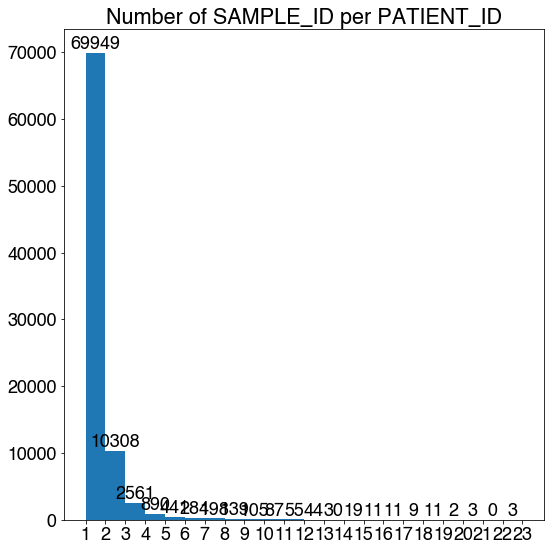

In [78]:
# distribution of # of samples per patient
plot_hist(df_impact, col_sample='SAMPLE_ID',col_patient='PATIENT_ID')

### Notes on cdm pathology_impact_sample_summary_dop table

- two samples that were flagged are already known, where the sample IDs cooresponded to different MRNs
- table is larger than # of cases w/ IMPACT on cbioportal because of reasons outlined: 
 - patients couldn've been consented to multiple pannels (i.e. Archer)
 - Patients only had partial consent to 12-245

In [79]:
query = 'select * from phi_data_lake."cdm-data".pathology."table_pathology_impact_sample_summary_dop_anno.tsv"'
df_cdm = dremio_session.get_table(query)
df_cdm = mrn_zero_pad(df_cdm, "MRN")
# invalid SAMPLE IDS flagged by Chris - coorespond to multple MRNs
invalid_dmp_ids = ['P-0000000-N-VR1', 'P-0032211-T02-IM6']
df_cdm = df_cdm[~df_cdm['SAMPLE_ID'].isin(invalid_dmp_ids)]
display(df_cdm)

print(f"Number of patients: {len(df_cdm['MRN'].unique())}")
print(f"Number of samples: {len(df_cdm['SAMPLE_ID'].unique())}")
print(f"Number of rows: {len(df_cdm)}")
print(f"Number of rows (removing duplicates): {len(df_cdm.drop_duplicates())}")


[INFO] Query:  select * from phi_data_lake."cdm-data".pathology."table_pathology_impact_sample_summary_dop_anno.tsv"


,MRN,SAMPLE_ID,SPECIMEN_NUMBER_DMP,SOURCE_ACCESSION_NUMBER_0,SOURCE_SPEC_NUM_0,SOURCE_ACCESSION_NUMBER_0b,SOURCE_SPEC_NUM_0b,ACCESSION_NUMBER_DMP,DATE_SEQUENCING_REPORT,REPORT_CMPT_DATE_SOURCE_0,REPORT_CMPT_DATE_SOURCE_0b,DATE_OF_PROCEDURE_SURGICAL,DATE_OF_PROCEDURE_SURGICAL_EST,DOP_COMPUTE_SOURCE
0,00000043,P-0078271-N01-IM7,1,,,,,DMG22-7104,2022-08-18,,,,,
1,00000043,P-0078271-T01-IM7,1,S22-14065,5,,,M22-44074,2022-10-18,2022-02-28,,2022-02-28,2022-02-28,Specimens Submitted
2,00000043,P-0078271-T02-IM7,1,S22-14065,1,,,M22-49603,2022-11-18,2022-02-28,,2022-02-28,2022-02-28,Specimens Submitted
3,00000094,P-0015526-T01-IM6,1,S16-53917,2,,,M16-23676,2016-10-11,2016-10-11,,,2016-10-11,Surgical
4,00000432,P-0001115-T01-IM3,1,S13-63415,1,,,M14-7442,2014-07-09,2013-12-04,,2013-12-04,2013-12-04,Specimens Submitted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186778,38324141,P-0102511-T01-XS1,1,,,,,M24-1983,2024-01-11,,,2024-01-10,2024-01-10,Specimens Submitted
186779,38324250,P-0102774-T01-XS1,1,,,,,M24-2176,2024-01-12,,,2024-01-11,2024-01-11,Specimens Submitted
186780,38324621,P-0102772-T01-XS1,1,,,,,M24-2423,2024-01-16,,,2024-01-12,2024-01-12,Specimens Submitted
186781,38324677,P-0102728-T01-XS1,1,,,,,M24-2572,2024-01-17,,,2024-01-16,2024-01-16,Specimens Submitted


Number of patients: 96210
Number of samples: 186778
Number of rows: 186778
Number of rows (removing duplicates): 186778


In [80]:
df_cdm['SOURCE_ACCESSION_NUMBER_0'] = df_cdm['SOURCE_ACCESSION_NUMBER_0'].replace('', np.nan)
df_cdm['SOURCE_SPEC_NUM_0'] = df_cdm['SOURCE_SPEC_NUM_0'].replace('', np.nan)

df_cdm = df_cdm.dropna(subset=['SOURCE_ACCESSION_NUMBER_0'])
df_cdm = df_cdm.dropna(subset=['SOURCE_SPEC_NUM_0'])

display(df_cdm)
print(f"Number of patients: {len(df_cdm['MRN'].unique())}")
print(f"Number of samples: {len(df_cdm['SAMPLE_ID'].unique())}")
print(f"Number of rows: {len(df_cdm)}")
print(f"Number of rows (removing duplicates): {len(df_cdm.drop_duplicates())}")



,MRN,SAMPLE_ID,SPECIMEN_NUMBER_DMP,SOURCE_ACCESSION_NUMBER_0,SOURCE_SPEC_NUM_0,SOURCE_ACCESSION_NUMBER_0b,SOURCE_SPEC_NUM_0b,ACCESSION_NUMBER_DMP,DATE_SEQUENCING_REPORT,REPORT_CMPT_DATE_SOURCE_0,REPORT_CMPT_DATE_SOURCE_0b,DATE_OF_PROCEDURE_SURGICAL,DATE_OF_PROCEDURE_SURGICAL_EST,DOP_COMPUTE_SOURCE
1,00000043,P-0078271-T01-IM7,1,S22-14065,5,,,M22-44074,2022-10-18,2022-02-28,,2022-02-28,2022-02-28,Specimens Submitted
2,00000043,P-0078271-T02-IM7,1,S22-14065,1,,,M22-49603,2022-11-18,2022-02-28,,2022-02-28,2022-02-28,Specimens Submitted
3,00000094,P-0015526-T01-IM6,1,S16-53917,2,,,M16-23676,2016-10-11,2016-10-11,,,2016-10-11,Surgical
4,00000432,P-0001115-T01-IM3,1,S13-63415,1,,,M14-7442,2014-07-09,2013-12-04,,2013-12-04,2013-12-04,Specimens Submitted
5,00000811,P-0002243-T01-IM3,1,S11-35974,1,,,M14-13639,2014-10-24,2011-07-25,,2011-07-25,2011-07-25,Specimens Submitted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186764,38323309,P-0102302-T01-AS5,1,S24-1241,3,,,M24-2063,2024-01-12,2024-01-05,,2023-12-05,2023-12-05,Specimens Submitted
186765,38323373,P-0102711-T01-IH4,1,H24-251,1,,,M24-2764,2024-01-17,2024-01-08,,2024-01-08,2024-01-08,Specimens Submitted
186767,38323655,P-0102472-T01-IH4,1,M24-1989,1,,,M24-1987,2024-01-11,2024-01-11,,2024-01-10,2024-01-10,Specimens Submitted
186768,38323672,P-0102632-T01-IH4,1,M24-2899,1,,,M24-2901,2024-01-18,2024-01-18,,2024-01-17,2024-01-17,Specimens Submitted


Number of patients: 78511
Number of samples: 133170
Number of rows: 133170
Number of rows (removing duplicates): 133170


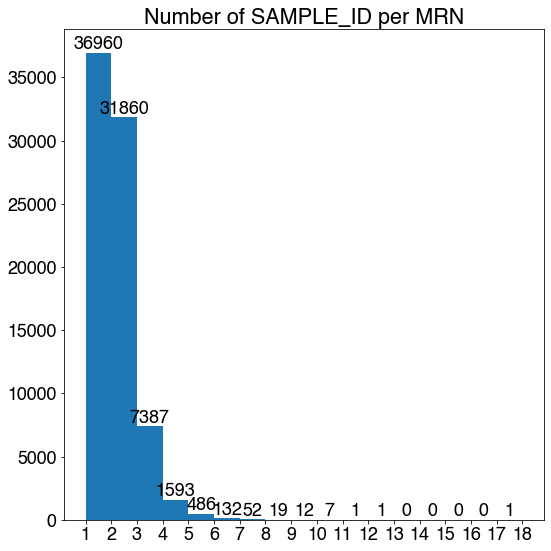

In [81]:
plot_hist(df_cdm, col_sample='SAMPLE_ID',col_patient='MRN')


In [82]:
df_impact = df_impact.merge(df_cdm, on='SAMPLE_ID', how='inner')
display(df_impact)
print(f"Number of patients (MRN): {len(df_impact['MRN'].unique())}")
print(f"Number of patients (Patient ID): {len(df_impact['PATIENT_ID'].unique())}")
print(f"Number of samples: {len(df_impact['SAMPLE_ID'].unique())}")
print(f"Number of rows: {len(df_impact)}")
print(f"Number of rows (removing duplicates): {len(df_impact.drop_duplicates())}")

,SAMPLE_ID,PATIENT_ID,GLEASON_SAMPLE_LEVEL,PDL1_POSITIVE,MONTH_ADDED,WEEK_ADDED,CANCER_TYPE,SAMPLE_TYPE,SAMPLE_CLASS,METASTATIC_SITE,PRIMARY_SITE,CANCER_TYPE_DETAILED,GENE_PANEL,SO_COMMENTS,SAMPLE_COVERAGE,TUMOR_PURITY,ONCOTREE_CODE,MSI_COMMENT,MSI_SCORE,MSI_TYPE,INSTITUTE,SOMATIC_STATUS,ARCHER,CVR_TMB_COHORT_PERCENTILE,CVR_TMB_SCORE,CVR_TMB_TT_COHORT_PERCENTILE,PATH_SLIDE_EXISTS,MSK_SLIDE_ID,LEVEL_1,LEVEL_2,LEVEL_3A,LEVEL_3B,LEVEL_4,LEVEL_R1,LEVEL_R2,HIGHEST_LEVEL,HIGHEST_SENSITIVE_LEVEL,HIGHEST_RESISTANCE_LEVEL,LEVEL_Dx1,LEVEL_Dx2,LEVEL_Dx3,HIGHEST_DX_LEVEL,LEVEL_Px1,LEVEL_Px2,LEVEL_Px3,HIGHEST_PX_LEVEL,ONCOGENIC_MUTATIONS,#ONCOGENIC_MUTATIONS,RESISTANCE_MUTATIONS,#RESISTANCE_MUTATIONS,#MUTATIONS_WITH_SENSITIVE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_RESISTANCE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_DIAGNOSTIC_IMPLICATIONS,#MUTATIONS_WITH_PROGNOSTIC_IMPLICATIONS,#MUTATIONS,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,ADRENAL_GLANDS,BONE,CNS_BRAIN,INTRA_ABDOMINAL,LIVER,LUNG,LYMPH_NODES,OTHER,PLEURA,REPRODUCTIVE_ORGANS,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,OTHER_PATIENT_ID,PARTA_CONSENTED_12_245,PARTC_CONSENTED_12_245,MRN,SPECIMEN_NUMBER_DMP,SOURCE_ACCESSION_NUMBER_0,SOURCE_SPEC_NUM_0,SOURCE_ACCESSION_NUMBER_0b,SOURCE_SPEC_NUM_0b,ACCESSION_NUMBER_DMP,DATE_SEQUENCING_REPORT,REPORT_CMPT_DATE_SOURCE_0,REPORT_CMPT_DATE_SOURCE_0b,DATE_OF_PROCEDURE_SURGICAL,DATE_OF_PROCEDURE_SURGICAL_EST,DOP_COMPUTE_SOURCE
0,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO,00229137,1,S13-57848,1,,,M13-9122,2013-11-06,2013-11-06,,,2013-11-06,Surgical
1,P-0000012-T02-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Breast Cancer,Primary,Tumor,Not Applicable,Breast,Breast Invasive Ductal Carcinoma,IMPACT341,,344,,IDC,MICROSATELLITE INSTABILITY-INDETERMINATE. See ...,4.10,Indeterminate,MSKCC,Matched,NO,17.1,1.1,13.5,NO,,,,,,,,,,,,,,,,,,,,TP53 p.T256P;MCL1 Amplification,2,,0,0,0,0,0,3,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO,00229137,1,S98-38399,1,,,M13-10317,2013-12-24,1998-12-02,,1998-12-02,1998-12-02,Specimens Submitted
2,P-0000012-T04-IM6,P-0000012,,,2018/08,"2018, Wk. 31",Non-Small Cell Lung Cancer,Primary,Tumor,Not Applicable,Lung,Lung Adenocarcinoma,IMPACT468,Note: The mutations and copy number profile su...,713,20,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.20,Stable,MSKCC,Matched,YES,78.5,7.9,64.1,YES,1103618,,,,,,,,,,,,,,,,,,,EP300 p.Q1455E,1,,0,0,0,0,0,10,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO,00229137,1,S18-37579,1,,,M18-19133,2018-06-21,2018-06-21,,,2018-06-21,Surgical & IR
3,P-0000004-T01-IM3,P-0000004,,,2015/04,"2015, Wk. 15",Breast Cancer,Primary,Tumor,Not Applicable,Breast,Breast Invasive Ductal Carcinoma,IMPACT341,,428,50,IDC,Not Available,2.50,Stable,MSKCC,Matched,NO,58.6,4.5,67.8,NO,,Capivasertib+Fulvestrant(AKT1 p.E17K),,,Capivasertib(AKT1 p.E17K),,,,LEVEL_1,LEVEL_1,,,,,,,,,,AKT1 p.E17K;TP53 p.A138Cfs*27;RAC1 Amplification,3,,0,1,0,0,0,7,FEMALE,WHITE,Non-Spanish; Non-Hispanic,40,Unknown,1,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,,,,Prior medications to MSK,3.780780484597429,1:DECEASED,DMP0004,YES,NO,35411298,1,S13-63310,1,,,M14-108,2014-01-07,2013-12-04,,2011-04-21,2011-04-21,Specimens Submitted
4,

Number of patients (MRN): 73536
Number of patients (Patient ID): 73536
Number of samples: 85932
Number of rows: 85932
Number of rows (removing duplicates): 85932


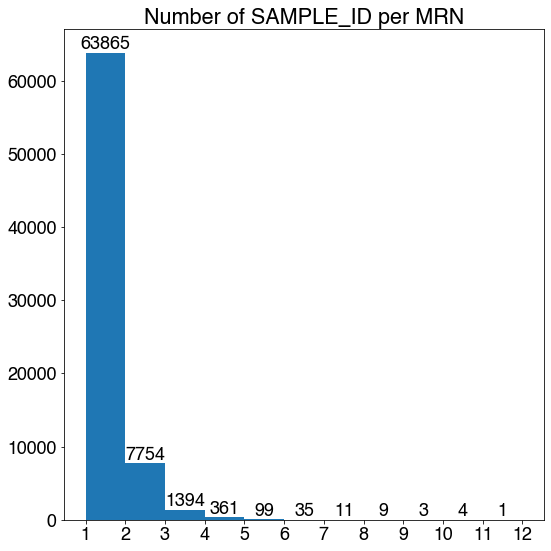

In [88]:
# relative drop off in number of IMPCAT samples per patient when inner joined on IMPACT table
plot_hist(df_impact, col_sample='SAMPLE_ID',col_patient='MRN')


## PDM Data Merges

Subsequent codeblocks are for merging data between IMPACT/CDM and HoBBIT and analyzing the results

In [84]:
display(df_hobbit)
df_merge_patient = df_impact.merge(df_hobbit, left_on='MRN', right_on='mrn', how='inner') #, how='left')
display(df_merge_patient)
print(f"Number of patients (MRN): {len(df_merge_patient['MRN'].unique())}")
print(f"Number of patients (Patient ID): {len(df_merge_patient['PATIENT_ID'].unique())}")
print(f"Number of samples: {len(df_merge_patient['SAMPLE_ID'].unique())}")
print(f"Number of slides: {len(df_merge_patient['image_id'].unique())}")

print(f"Number of rows: {len(df_merge_patient)}")
print(f"Number of rows (removing duplicates): {len(df_merge_patient.drop_duplicates())}")


# print(len(set(df_merge_patient['MRN'].to_list())))
# print(len(set(df_merge_patient['SAMPLE_ID'].to_list())))
# print(len(set(df_merge_patient['image_id'].to_list())))


,mrn,specnum_formatted,specclass_id,subspecialty,priority,reduced_priority,datetime_accession,signout_datetime,part_inst,part_designator,part_type,part_description,block_inst,blkdesig_label,barcode,stain_inst,stain_name,stain_group,scanner_id,brand,model,image_id,magnification,status_id,file_size_bytes,captured_datetime
0,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,1,1,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC RIGHT, (VVS-06...",NaN,None,S06-26206;S1;MSKQ,1,None,None,IPTH9025,aperio,AT2,1006098,20x,$ready,8.400788e+08,2018-03-29 03:22:00
1,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,2,2,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC LEFT, (VVS-06-...",NaN,None,S06-26206;S2;MSKR,2,None,None,IPTH9025,aperio,AT2,1006102,20x,$updated,1.151277e+09,2018-03-29 03:25:00
2,35134183,S06-26206,SSL,.GYN,RUSH,other,2006-07-10 17:38:31.617,2006-07-11 15:51:26.980,2,2,SURGICAL SUBMITTED SLIDES,"OVARY WITH TUBE, NON-NEOPLASTIC LEFT, (VVS-06-...",NaN,None,S06-26206;S2;MSKR,2,None,None,IPTH9025,aperio,AT2,1006106,20x,$updated,9.570065e+08,2018-03-29 03:28:00
3,35039238,S04-43827,R,.GYN,C3,inhouse-surgical,2004-12-06 10:09:09.027,2004-12-09 19:19:54.897,2,2,SMALL BOWEL; BIOPSY,SP: Small bowel (fs) (pjm),NaN,None,S04-43827;S34;MSKS,34,None,None,IPTH9007,aperio,AT2,1011421,20x,$ready,8.993040e+08,2018-04-04 16:55:00
4,00673679,S00-12444,R,None,C,inhouse-surgical,2000-04-24 15:57:00.000,2000-04-28 07:55:00.000,2,2,FROZEN SECTION (FIRST),SP: Prostate and seminal vesicles (fs)(cg),NaN,None,S00-12444;S7;MSKP,7,None,None,IPTH9007,aperio,AT2,1022373,20x,$ready,2.337103e+09,2018-04-14 01:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6277512,35163877,S15-55469,R,None,C4,inhouse-surgical,2015-10-02 15:41:19.530,2015-10-09 20:15:38.800,5,5,BREAST; LUMPECTOMY/EXCISION,"Breast, right, medial margin",25.0,3 SS,S15-55469;S25;MSKP,25,"H&E, Initial",H&E (Initial),SS12004,aperio,GT450,4063822,40x,$ready,1.406952e+09,2021-02-22 17:16:00
6277513,38146362,H21-831,HSSL,.Heme,Submitted+,consult,2021-02-04 10:22:13.110,2021-02-17 11:40:43.900,1,1,SURGICAL SUBMITTED SLIDES,"Biopsies, left parietal bone (60-S-20-012098, ...",2.0,60S20-12098_2B,H21-831;S8;MSKW,8,CD3 (Leu4),None,SS12029,aperio,GT450,4063823,40x,$ready,9.162542e+08,2021-02-22 17:20:00
6277514,38142311,M21-5713,DM,.GI,DM1,other,2021-02-12 16:51:48.343,2021-03-05 15:49:10.077,1,1,DM SUBMITTED SLIDES,"Liver; biopsy (MSK:S21-1546/1-2 GI, DOP:1/8/20...",NaN,None,M21-5713;S2;MSKZ,2,DM H&E RECUT,H&E (Other),IPTH9026,aperio,AT2,4063824,20x,$ready,1.230379e+08,2021-02-22 17:19:00
6277515,00995151,S21-8498,R,.GI,Surgical,inhouse-surgical,2021-02-09 16:11:20.550,2021-02-17 15:28:53.453,1,1,ESOPHAGUS; ESOPHAGECTOMY,Esophagogastrectomy freeze esophageal margin (fs),1.0,1 FSC,S21-8498;S1;MSKG,1,"H&E, Initial",H&E (Initial),IPTHE006,aperio,AT2,4063825,20x,$ready,2.486275e+08,2021-02-22 17:19:00


,SAMPLE_ID,PATIENT_ID,GLEASON_SAMPLE_LEVEL,PDL1_POSITIVE,MONTH_ADDED,WEEK_ADDED,CANCER_TYPE,SAMPLE_TYPE,SAMPLE_CLASS,METASTATIC_SITE,PRIMARY_SITE,CANCER_TYPE_DETAILED,GENE_PANEL,SO_COMMENTS,SAMPLE_COVERAGE,TUMOR_PURITY,ONCOTREE_CODE,MSI_COMMENT,MSI_SCORE,MSI_TYPE,INSTITUTE,SOMATIC_STATUS,ARCHER,CVR_TMB_COHORT_PERCENTILE,CVR_TMB_SCORE,CVR_TMB_TT_COHORT_PERCENTILE,PATH_SLIDE_EXISTS,MSK_SLIDE_ID,LEVEL_1,LEVEL_2,LEVEL_3A,LEVEL_3B,LEVEL_4,LEVEL_R1,LEVEL_R2,HIGHEST_LEVEL,HIGHEST_SENSITIVE_LEVEL,HIGHEST_RESISTANCE_LEVEL,LEVEL_Dx1,LEVEL_Dx2,LEVEL_Dx3,HIGHEST_DX_LEVEL,LEVEL_Px1,LEVEL_Px2,LEVEL_Px3,HIGHEST_PX_LEVEL,ONCOGENIC_MUTATIONS,#ONCOGENIC_MUTATIONS,RESISTANCE_MUTATIONS,#RESISTANCE_MUTATIONS,#MUTATIONS_WITH_SENSITIVE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_RESISTANCE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_DIAGNOSTIC_IMPLICATIONS,#MUTATIONS_WITH_PROGNOSTIC_IMPLICATIONS,#MUTATIONS,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,ADRENAL_GLANDS,BONE,CNS_BRAIN,INTRA_ABDOMINAL,LIVER,LUNG,LYMPH_NODES,OTHER,PLEURA,REPRODUCTIVE_ORGANS,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,OTHER_PATIENT_ID,PARTA_CONSENTED_12_245,PARTC_CONSENTED_12_245,MRN,SPECIMEN_NUMBER_DMP,SOURCE_ACCESSION_NUMBER_0,SOURCE_SPEC_NUM_0,SOURCE_ACCESSION_NUMBER_0b,SOURCE_SPEC_NUM_0b,ACCESSION_NUMBER_DMP,DATE_SEQUENCING_REPORT,REPORT_CMPT_DATE_SOURCE_0,REPORT_CMPT_DATE_SOURCE_0b,DATE_OF_PROCEDURE_SURGICAL,DATE_OF_PROCEDURE_SURGICAL_EST,DOP_COMPUTE_SOURCE,mrn,specnum_formatted,specclass_id,subspecialty,priority,reduced_priority,datetime_accession,signout_datetime,part_inst,part_designator,part_type,part_description,block_inst,blkdesig_label,barcode,stain_inst,stain_name,stain_group,scanner_id,brand,model,image_id,magnification,status_id,file_size_bytes,captured_datetime
0,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO,00229137,1,S13-57848,1,,,M13-9122,2013-11-06,2013-11-06,,,2013-11-06,Surgical,00229137,S18-37579,R,.Thoracic,BX+,inhouse-biopsy,2018-06-21 11:01:38.507,2018-06-26 19:42:19.597,1,1,LUNG; BIOPSY,"Lung, left",1.0,1 THOR,S18-37579;S3;MSKQ,3,TTF-1,IHC,IPTH9025,aperio,AT2,1103914,20x,$ready,1.371043e+08,2018-07-03 16:22:00
1,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO,00229137,1,S13-57848,1,,,M13-9122,2013-11-06,2013-11-06,,,2013-11-06,Surgical,00229137,S18-37579,R,.Thoracic,BX+,inhouse-biopsy,2018-06-21 11:01:38.507,2018-06-26 19:42:19.597,1,1,LUNG; BIOPSY,"Lung, left",1.0,1 THOR,S18-37579;S1;MSKO,1,"H&E, Initial",H&E (Initial),IPTH9026,aperio,AT2,1103971,20x,$ready,1.179002e+08,2018-07-03 16:49:00
2,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO,

Number of patients (MRN): 66610
Number of patients (Patient ID): 66610
Number of samples: 78309
Number of slides: 1605757
Number of rows: 2128958
Number of rows (removing duplicates): 2128958


In [86]:
df_merge_accession = df_impact.merge(df_hobbit, left_on=['MRN', 'SOURCE_ACCESSION_NUMBER_0'], right_on=['mrn','specnum_formatted'], how='inner') #, how='left')
print(f"Number of patients (MRN): {len(df_merge_accession['MRN'].unique())}")
print(f"Number of patients (Patient ID): {len(df_merge_accession['PATIENT_ID'].unique())}")
print(f"Number of samples: {len(df_merge_accession['SAMPLE_ID'].unique())}")
print(f"Number of slides: {len(df_merge_accession['image_id'].unique())}")

print(f"Number of rows: {len(df_merge_accession)}")
print(f"Number of rows (removing duplicates): {len(df_merge_accession.drop_duplicates())}")



Number of patients (MRN): 59248
Number of patients (Patient ID): 59248
Number of samples: 68449
Number of slides: 666365
Number of rows: 690552
Number of rows (removing duplicates): 690552


In [87]:
df_hobbit['part_inst'] = df_hobbit['part_inst'].astype(str)
df_merge_part = df_impact.merge(df_hobbit, left_on=['MRN', 'SOURCE_ACCESSION_NUMBER_0', 'SOURCE_SPEC_NUM_0'], right_on=['mrn','specnum_formatted', 'part_inst'], how='inner') #, how='left')
# df_hobb
display(df_merge_part)
print(f"Number of patients (MRN): {len(df_merge_part['MRN'].unique())}")
print(f"Number of patients (Patient ID): {len(df_merge_part['PATIENT_ID'].unique())}")
print(f"Number of samples: {len(df_merge_part['SAMPLE_ID'].unique())}")
print(f"Number of slides: {len(df_merge_part['image_id'].unique())}")

print(f"Number of rows: {len(df_merge_part)}")
print(f"Number of rows (removing duplicates): {len(df_merge_part.drop_duplicates())}")



,SAMPLE_ID,PATIENT_ID,GLEASON_SAMPLE_LEVEL,PDL1_POSITIVE,MONTH_ADDED,WEEK_ADDED,CANCER_TYPE,SAMPLE_TYPE,SAMPLE_CLASS,METASTATIC_SITE,PRIMARY_SITE,CANCER_TYPE_DETAILED,GENE_PANEL,SO_COMMENTS,SAMPLE_COVERAGE,TUMOR_PURITY,ONCOTREE_CODE,MSI_COMMENT,MSI_SCORE,MSI_TYPE,INSTITUTE,SOMATIC_STATUS,ARCHER,CVR_TMB_COHORT_PERCENTILE,CVR_TMB_SCORE,CVR_TMB_TT_COHORT_PERCENTILE,PATH_SLIDE_EXISTS,MSK_SLIDE_ID,LEVEL_1,LEVEL_2,LEVEL_3A,LEVEL_3B,LEVEL_4,LEVEL_R1,LEVEL_R2,HIGHEST_LEVEL,HIGHEST_SENSITIVE_LEVEL,HIGHEST_RESISTANCE_LEVEL,LEVEL_Dx1,LEVEL_Dx2,LEVEL_Dx3,HIGHEST_DX_LEVEL,LEVEL_Px1,LEVEL_Px2,LEVEL_Px3,HIGHEST_PX_LEVEL,ONCOGENIC_MUTATIONS,#ONCOGENIC_MUTATIONS,RESISTANCE_MUTATIONS,#RESISTANCE_MUTATIONS,#MUTATIONS_WITH_SENSITIVE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_RESISTANCE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_DIAGNOSTIC_IMPLICATIONS,#MUTATIONS_WITH_PROGNOSTIC_IMPLICATIONS,#MUTATIONS,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,ADRENAL_GLANDS,BONE,CNS_BRAIN,INTRA_ABDOMINAL,LIVER,LUNG,LYMPH_NODES,OTHER,PLEURA,REPRODUCTIVE_ORGANS,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,OTHER_PATIENT_ID,PARTA_CONSENTED_12_245,PARTC_CONSENTED_12_245,MRN,SPECIMEN_NUMBER_DMP,SOURCE_ACCESSION_NUMBER_0,SOURCE_SPEC_NUM_0,SOURCE_ACCESSION_NUMBER_0b,SOURCE_SPEC_NUM_0b,ACCESSION_NUMBER_DMP,DATE_SEQUENCING_REPORT,REPORT_CMPT_DATE_SOURCE_0,REPORT_CMPT_DATE_SOURCE_0b,DATE_OF_PROCEDURE_SURGICAL,DATE_OF_PROCEDURE_SURGICAL_EST,DOP_COMPUTE_SOURCE,mrn,specnum_formatted,specclass_id,subspecialty,priority,reduced_priority,datetime_accession,signout_datetime,part_inst,part_designator,part_type,part_description,block_inst,blkdesig_label,barcode,stain_inst,stain_name,stain_group,scanner_id,brand,model,image_id,magnification,status_id,file_size_bytes,captured_datetime
0,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO,00229137,1,S13-57848,1,,,M13-9122,2013-11-06,2013-11-06,,,2013-11-06,Surgical,00229137,S13-57848,R,.Heme,C7,inhouse-surgical,2013-11-06 10:13:05.773,2013-11-14 18:03:46.277,1,1,LYMPH NODE; BIOPSY,Left deep neck node (fs),1.0,1 FSC,S13-57848;S2;msk,2,FROZEN SECTION,Frozen,IPTH9006,aperio,AT2,322524,20x,$ready,27451081.0,2013-11-18 08:34:00
1,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO,00229137,1,S13-57848,1,,,M13-9122,2013-11-06,2013-11-06,,,2013-11-06,Surgical,00229137,S13-57848,R,.Heme,C7,inhouse-surgical,2013-11-06 10:13:05.773,2013-11-14 18:03:46.277,1,1,LYMPH NODE; BIOPSY,Left deep neck node (fs),1.0,1 FSC,S13-57848;S1;msk,1,"H&E, Initial",H&E (Initial),IPTH9006,aperio,AT2,322525,20x,$ready,183968501.0,2013-11-18 08:35:00
2,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122

Number of patients (MRN): 58506
Number of patients (Patient ID): 58506
Number of samples: 67542
Number of slides: 466557
Number of rows: 475320
Number of rows (removing duplicates): 475320


In [89]:
df_merge_part

,SAMPLE_ID,PATIENT_ID,GLEASON_SAMPLE_LEVEL,PDL1_POSITIVE,MONTH_ADDED,WEEK_ADDED,CANCER_TYPE,SAMPLE_TYPE,SAMPLE_CLASS,METASTATIC_SITE,PRIMARY_SITE,CANCER_TYPE_DETAILED,GENE_PANEL,SO_COMMENTS,SAMPLE_COVERAGE,TUMOR_PURITY,ONCOTREE_CODE,MSI_COMMENT,MSI_SCORE,MSI_TYPE,INSTITUTE,SOMATIC_STATUS,ARCHER,CVR_TMB_COHORT_PERCENTILE,CVR_TMB_SCORE,CVR_TMB_TT_COHORT_PERCENTILE,PATH_SLIDE_EXISTS,MSK_SLIDE_ID,LEVEL_1,LEVEL_2,LEVEL_3A,LEVEL_3B,LEVEL_4,LEVEL_R1,LEVEL_R2,HIGHEST_LEVEL,HIGHEST_SENSITIVE_LEVEL,HIGHEST_RESISTANCE_LEVEL,LEVEL_Dx1,LEVEL_Dx2,LEVEL_Dx3,HIGHEST_DX_LEVEL,LEVEL_Px1,LEVEL_Px2,LEVEL_Px3,HIGHEST_PX_LEVEL,ONCOGENIC_MUTATIONS,#ONCOGENIC_MUTATIONS,RESISTANCE_MUTATIONS,#RESISTANCE_MUTATIONS,#MUTATIONS_WITH_SENSITIVE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_RESISTANCE_THERAPEUTIC_IMPLICATIONS,#MUTATIONS_WITH_DIAGNOSTIC_IMPLICATIONS,#MUTATIONS_WITH_PROGNOSTIC_IMPLICATIONS,#MUTATIONS,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,ADRENAL_GLANDS,BONE,CNS_BRAIN,INTRA_ABDOMINAL,LIVER,LUNG,LYMPH_NODES,OTHER,PLEURA,REPRODUCTIVE_ORGANS,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,OTHER_PATIENT_ID,PARTA_CONSENTED_12_245,PARTC_CONSENTED_12_245,MRN,SPECIMEN_NUMBER_DMP,SOURCE_ACCESSION_NUMBER_0,SOURCE_SPEC_NUM_0,SOURCE_ACCESSION_NUMBER_0b,SOURCE_SPEC_NUM_0b,ACCESSION_NUMBER_DMP,DATE_SEQUENCING_REPORT,REPORT_CMPT_DATE_SOURCE_0,REPORT_CMPT_DATE_SOURCE_0b,DATE_OF_PROCEDURE_SURGICAL,DATE_OF_PROCEDURE_SURGICAL_EST,DOP_COMPUTE_SOURCE,mrn,specnum_formatted,specclass_id,subspecialty,priority,reduced_priority,datetime_accession,signout_datetime,part_inst,part_designator,part_type,part_description,block_inst,blkdesig_label,barcode,stain_inst,stain_name,stain_group,scanner_id,brand,model,image_id,magnification,status_id,file_size_bytes,captured_datetime
0,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO,00229137,1,S13-57848,1,,,M13-9122,2013-11-06,2013-11-06,,,2013-11-06,Surgical,00229137,S13-57848,R,.Heme,C7,inhouse-surgical,2013-11-06 10:13:05.773,2013-11-14 18:03:46.277,1,1,LYMPH NODE; BIOPSY,Left deep neck node (fs),1.0,1 FSC,S13-57848;S2;msk,2,FROZEN SECTION,Frozen,IPTH9006,aperio,AT2,322524,20x,$ready,27451081.0,2013-11-18 08:34:00
1,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122.59591675707662,0:LIVING,,YES,NO,00229137,1,S13-57848,1,,,M13-9122,2013-11-06,2013-11-06,,,2013-11-06,Surgical,00229137,S13-57848,R,.Heme,C7,inhouse-surgical,2013-11-06 10:13:05.773,2013-11-14 18:03:46.277,1,1,LYMPH NODE; BIOPSY,Left deep neck node (fs),1.0,1 FSC,S13-57848;S1;msk,1,"H&E, Initial",H&E (Initial),IPTH9006,aperio,AT2,322525,20x,$ready,183968501.0,2013-11-18 08:35:00
2,P-0000012-T03-IM3,P-0000012,,,2015/04,"2015, Wk. 15",Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,IMPACT341,,428,,LUAD,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,MSKCC,Matched,NO,96.7,33.5,98.3,NO,,,,,,,,,,,,,,,,,,,,FBXW7 p.X413_splice;FBXW7 p.G61*;MAP3K1 p.E302...,11,,0,0,0,0,0,31,FEMALE,WHITE,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,,,No,Unknown,122